# k-NN Classification for MNiST 

16307110216 Ruian He

### Extract data from downloaded files

As the data is stored in bytes, we need to follow the strcture of the files to extract.

In [1]:
import numpy as np
import gzip,struct,os


'''
[offset] [type]          [value]          [description]
0000     32 bit integer  0x00000803(2051) magic number
0004     32 bit integer  60000            number of images
0008     32 bit integer  28               number of rows
0012     32 bit integer  28               number of columns
0016     unsigned byte   ??               pixel
'''

def extract_image(file_path):
    print("Extracting:",file_path)
    with gzip.GzipFile(fileobj=open(file_path,mode='rb')) as buf:
        magic,num,row,col = struct.unpack('>4I',buf.read(4*4))
        if magic != 2051:
            raise ValueError('Invalid magic number %d in MNIST image file: %s' %(magic, file_path))
        image = np.frombuffer(buf.read(num*row*col), dtype=np.uint8)
        return image.reshape(num,row,col).astype(int)
    
'''
[offset] [type]          [value]          [description]
0000     32 bit integer  0x00000801(2049) magic number (MSB first)
0004     32 bit integer  60000            number of items
0008     unsigned byte   ??               label
'''
    
def extract_label(file_path):
    print("Extracting:",file_path)
    with gzip.GzipFile(fileobj=open(file_path,mode='rb')) as buf:
        magic,num = struct.unpack('>2I',buf.read(2*4))
        if magic != 2049:
            raise ValueError('Invalid magic number %d in MNIST label file: %s' %(magic, file_path))
        label = np.frombuffer(buf.read(num), dtype=np.uint8)
        return label.astype(int)

Then we do the above approaches on our MNIST dataset.

In [2]:
data_dir = '../minist'

train_image_file = "train-images-idx3-ubyte.gz"
train_label_file = "train-labels-idx1-ubyte.gz"
test_image_file = "t10k-images-idx3-ubyte.gz"
test_label_file = "t10k-labels-idx1-ubyte.gz"

X_train = extract_image(os.path.join(data_dir,train_image_file))
print('Training data shape: ', X_train.shape)
y_train = extract_label(os.path.join(data_dir,train_label_file))
print('Training labels shape: ', y_train.shape)
X_test = extract_image(os.path.join(data_dir,test_image_file))
print('Test data shape: ', X_test.shape)
y_test = extract_label(os.path.join(data_dir,test_label_file))
print('Test labels shape: ', y_test.shape)

Extracting: minist/train-images-idx3-ubyte.gz
Training data shape:  (60000, 28, 28)
Extracting: minist/train-labels-idx1-ubyte.gz
Training labels shape:  (60000,)
Extracting: minist/t10k-images-idx3-ubyte.gz
Test data shape:  (10000, 28, 28)
Extracting: minist/t10k-labels-idx1-ubyte.gz
Test labels shape:  (10000,)


### Visualize the dataset

First of all, we are interested in how the dataset looks like and whether it is valid.

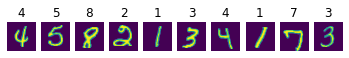

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

choice = np.random.choice(X_test.shape[0],10)
random_image = X_test[choice]
random_label = y_test[choice]

fig,ax = plt.subplots(1,10)
for i in range(10):
    ax[i].set_title(random_label[i])
    ax[i].imshow(random_image[i])
    ax[i].axis('off')

### kNN Model

Next, we start to build kNN model from scratch.

For specified train set and test set, we can easily calculate the distance between every point pairs.The distance between two point in 1-dimension is `sqrt(x1^2+x2^2-2*x1*x2)`, so we know in image space the distance is `sqrt(sum(x1i^2)+sum(x2i^2)-2*sum(x1i*x2i))`.

In [4]:
class KNearestNeighbor(object):
    def __init__(self):
        self.pre_X = None
        self.pre_dists = None

    # Store all train set points
    def train(self, X, y):
        self.X_train = X
        self.y_train = y
        
    # Predict test set with specified k
    def predict(self, X, k=1):
        if (self.pre_X != X).any():
            self.pre_X = X
            self.pre_dists = self.compute_distances(X)
        return self.predict_labels(self.pre_dists, k=k)
        
    # Compute distances between test and train
    def compute_distances(self, X):
        num_test = X.shape[0]
        num_train = self.X_train.shape[0]
        dists = np.zeros((num_test, num_train)) 
        dists = np.sqrt((self.X_train.dot(X.T)*(-2)+np.sum(np.square(X),axis=1)).T+np.sum(np.square(self.X_train),axis=1))
        return dists
    
    # Use argmax to select k neighbors
    def predict_labels(self, dists, k=1):
        num_test = dists.shape[0]
        y_pred = np.zeros(num_test)
        for i in range(num_test):
            closest_y = []
            # argsort returns the indices that would sort an array
            closest_y=self.y_train[np.argsort(dists[i,:])][:k]
            # bincount count number of occurrences of each value in array of non-negative ints
            y_pred[i]=np.argmax(np.bincount(closest_y))
        return y_pred

### Train the model

Now we get the model and the data,then we can start training and testing.And the final result is the same as K-nearest-neighbors, Euclidean (L2) 3.09% error rate by Kenneth Wilder, U. Chicago.

(60000, 784) (10000, 784)


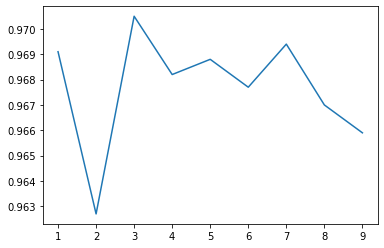

In [5]:
# first reshape train data to fit matrix calculus
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

# then test model with different k
model = KNearestNeighbor()
model.train(X_train,y_train)

accuracy = []
for j in range(1,10):
    y_pred = model.predict(X_test,j)
    accuracy.append(np.sum(y_test == y_pred)/y_test.shape[0])
    
plt.figure()
plt.plot(range(1,10),accuracy)

In [6]:
print("The best accuracy is:",accuracy[2])

The best accuracy is: 0.9705
